In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import os
from PIL import Image

In [2]:
from cityscapedataset import Dataset, CityScapeClasses
from cityscapeunet import UNet

In [3]:
classes = CityScapeClasses().classes
classes

['road',
 'sidewalk',
 'building',
 'fence',
 'pedestrian-railing',
 'pole',
 'traffic-light',
 'traffic-sign',
 'tree',
 'vegetation',
 'sky',
 'person',
 'rider',
 'car',
 'truck',
 'bus',
 'train',
 'motorcycle',
 'bicycle',
 'misc']

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tds = Dataset('train', im_size=(512,1024))
val_ds = Dataset('val', im_size=(512,1024), length=10)

In [5]:
class GPUDL():
    def __init__(self, dl):
        self.dl = dl
    def __iter__(self):
        for xb, yb in self.dl:
            yield xb.to(device, non_blocking=True),yb.to(device, non_blocking=True)
    def __len__(self):
        return len(self.dl)

In [6]:
import time

In [7]:
from unet_utils import miou, pixelwiseacc

In [8]:
def train(model, lr, batch_size, epochs, weight_decay, tds, val_ds):
    optim = torch.optim.SGD(model.parameters(), lr, weight_decay=weight_decay, momentum=0.9)
    loss_fn = nn.CrossEntropyLoss()
    
    dl = GPUDL(torch.utils.data.DataLoader(tds, batch_size, shuffle=True, num_workers=1))
    val_dl = GPUDL(torch.utils.data.DataLoader(val_ds, batch_size,num_workers=1))
    
    model.to(device)
    
    sched = torch.optim.lr_scheduler.OneCycleLR(optim, lr, epochs=epochs, steps_per_epoch=len(dl))
    
    losses = []
    val_losses = []
    mious = []
    val_mious = []
    paccs = []
    val_paccs = []
    for epoch in range(epochs):
        begin = time.time()
        losses.append([])
        val_losses.append([])
        mious.append([]) 
        val_mious.append([])
        paccs.append([])
        val_paccs.append([])
        for xb, yb in dl:
            preds = model(xb)
            loss = loss_fn(preds, yb)
            optim.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_value_(model.parameters(),0.1)
            optim.step()
            sched.step()
            
            losses[epoch].append(loss.item())
            mious[epoch].append(miou(preds,yb))
            paccs[epoch].append(pixelwiseacc(preds,yb))
            del(xb);del(yb);del(preds);del(loss);torch.cuda.empty_cache()
        
        with torch.no_grad():
            model.eval()
            for val_xb, val_yb in val_dl:
                val_preds = model(val_xb)
                val_loss = loss_fn(val_preds, val_yb)
                val_losses[epoch].append(val_loss.item())
                val_mious[epoch].append(miou(val_preds,val_yb))
                val_paccs[epoch].append(pixelwiseacc(val_preds,val_yb))
                del(val_xb);del(val_yb);del(val_preds);del(val_loss);torch.cuda.empty_cache()
            model.train()
        print('Epoch:', epoch + 1, 'TrainLoss:', f'{np.mean(losses[epoch]):.4f}', 'TMiou',f'{np.mean(mious[epoch]):.4f}', 'TPacc', f'{np.mean(paccs[epoch]):.4f}') 
        print('ValLoss', f'{np.mean(val_losses[epoch]):.4f},','VMiou',f'{np.mean(val_mious[epoch]):.4f}', 'VPacc', f'{np.mean(val_paccs[epoch]):.4f}',
              f'{((time.time() - begin) / 60):.2f}', 'minutes')
    return losses, val_losses

In [9]:
model = UNet(no_deconv=True)

In [10]:
##hyperparams
lr = 0.02
batch_size = 3
epochs = 20
weight_decay = 0.000005

In [11]:
losses, val_losses = train(model, lr, batch_size, epochs, weight_decay, tds, val_ds)

Epoch: 1 TrainLoss: 0.9572 TMiou 0.1847 TPacc 0.7370
ValLoss 0.6500, VMiou 0.2206 VPacc 0.8136 27.92 minutes
Epoch: 2 TrainLoss: 0.6447 TMiou 0.2383 TPacc 0.8133
ValLoss 0.5050, VMiou 0.2500 VPacc 0.8568 27.89 minutes
Epoch: 3 TrainLoss: 0.5479 TMiou 0.2675 TPacc 0.8395
ValLoss 0.4648, VMiou 0.2563 VPacc 0.8749 27.88 minutes
Epoch: 4 TrainLoss: 0.4831 TMiou 0.2880 TPacc 0.8555
ValLoss 0.4194, VMiou 0.2908 VPacc 0.8887 27.89 minutes
Epoch: 5 TrainLoss: 0.4371 TMiou 0.3038 TPacc 0.8671
ValLoss 0.3949, VMiou 0.3128 VPacc 0.8924 27.90 minutes
Epoch: 6 TrainLoss: 0.4036 TMiou 0.3158 TPacc 0.8752
ValLoss 0.3587, VMiou 0.3218 VPacc 0.8989 27.90 minutes
Epoch: 7 TrainLoss: 0.3749 TMiou 0.3268 TPacc 0.8827
ValLoss 0.2948, VMiou 0.3203 VPacc 0.9107 27.93 minutes
Epoch: 8 TrainLoss: 0.3535 TMiou 0.3345 TPacc 0.8876
ValLoss 0.3004, VMiou 0.3377 VPacc 0.9054 27.93 minutes
Epoch: 9 TrainLoss: 0.3372 TMiou 0.3419 TPacc 0.8926
ValLoss 0.3122, VMiou 0.3475 VPacc 0.9089 27.92 minutes
Epoch: 10 TrainLoss

In [12]:
with open('../working/Unet20epochs.pt', 'wb') as f:
    pass
torch.save(model.state_dict(), '../working/Unet20epochs.pt')

# Prediction on Dataset

In [13]:
img, label = val_ds[12]

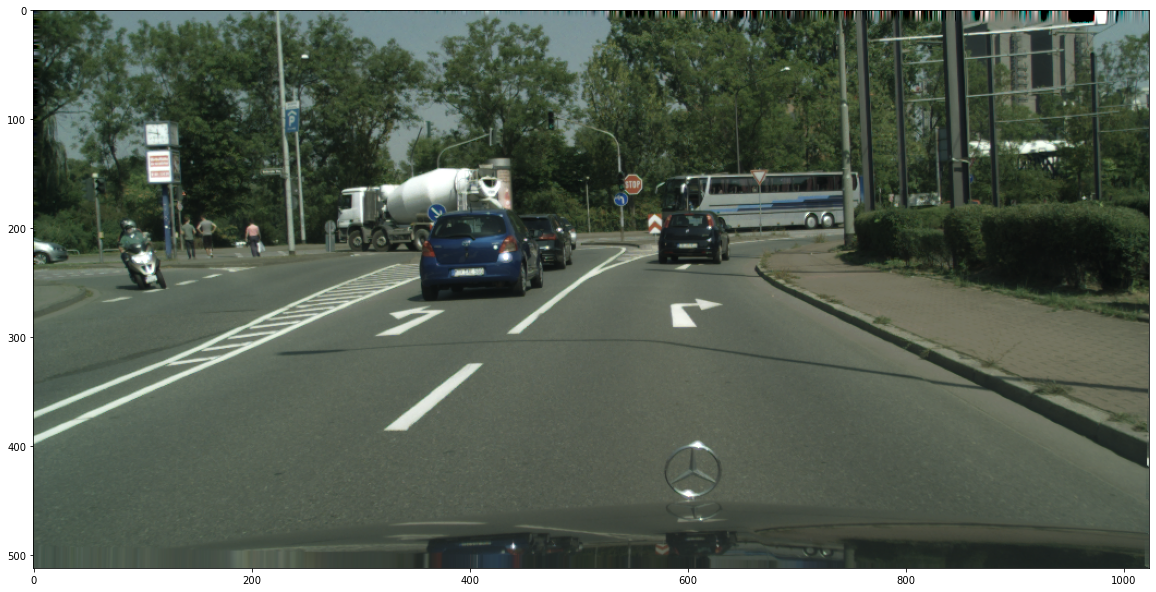

In [14]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot()
ax.imshow(img.permute(1,2,0))

## Ground Truth Value

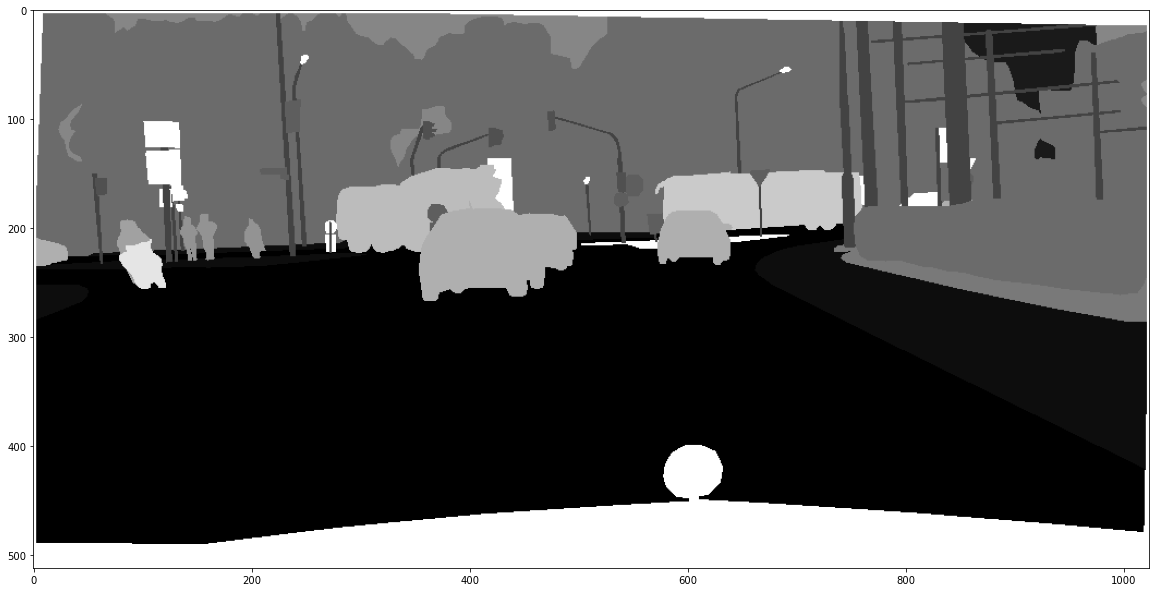

In [15]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot()
ax.imshow(label, cmap='gray')

## Prediction indices visualized

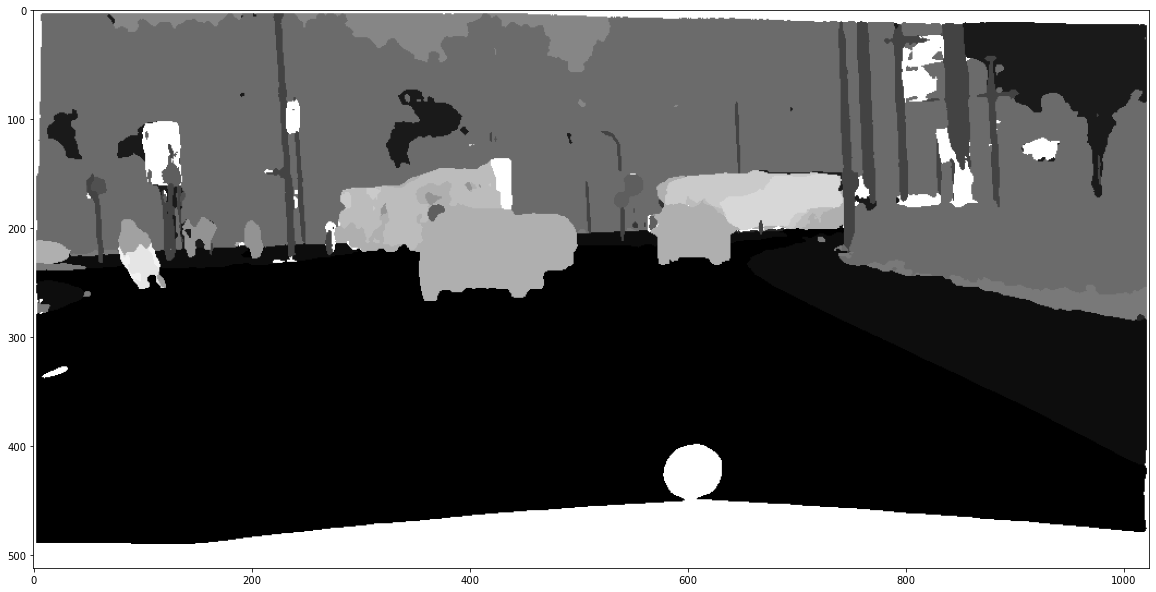

In [16]:
pred = model(img.to(device).reshape(-1,3,512,1024)).reshape(20,512,1024)
asdf, idxs = torch.max(pred, dim=0)
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot()
ax.imshow(idxs.cpu(), cmap='gray')

### Prediction on Valildation Data

NameError: name 'colorify' is not defined

In [19]:
def colorify(idxs, img_shape, figsize=(20,20)):
    idxs = np.array(idxs.to('cpu'))
    assert img_shape[0] == idxs.shape[0] and img_shape[1] == idxs.shape[1]
                          ##road         ##sidelwalk    building        fence       p-railing       pole      traffic-light
    colors = np.array([[162, 75, 175], [244,31,181], [113,103,112], [100,75,44], [147,98,39], [203,202,190], [219,169,42],
                 [255,246,69], [21,149,18], [155,243,154], [39,201,200], [234,22,47], [255,0,30], [39,62,163]])
                   #traffic-sign    ##tree       vegetation       sky         person       rider         car
    colors = np.append(colors, ([[78,105,221], [128,147,224], [82,96,159], [94,19,36], [123,48,66], [0,0,0]]))
                                   #truck           bus           train       motorcycle   bicycle     misc
    colors = colors.reshape((20,3))
    
    
    cmap = torch.zeros((3,img_shape[0], img_shape[1])).long()
    
    for i in range(len(colors)):
        cmap[0,idxs==i] = colors[i][0]
        cmap[1,idxs==i] = colors[i][1]
        cmap[2,idxs==i] = colors[i][2]
    
    fig = plt.figure(figsize=(figsize[0], figsize[1]))
    ax = fig.add_subplot()
    ax.imshow(cmap.permute(1,2,0))

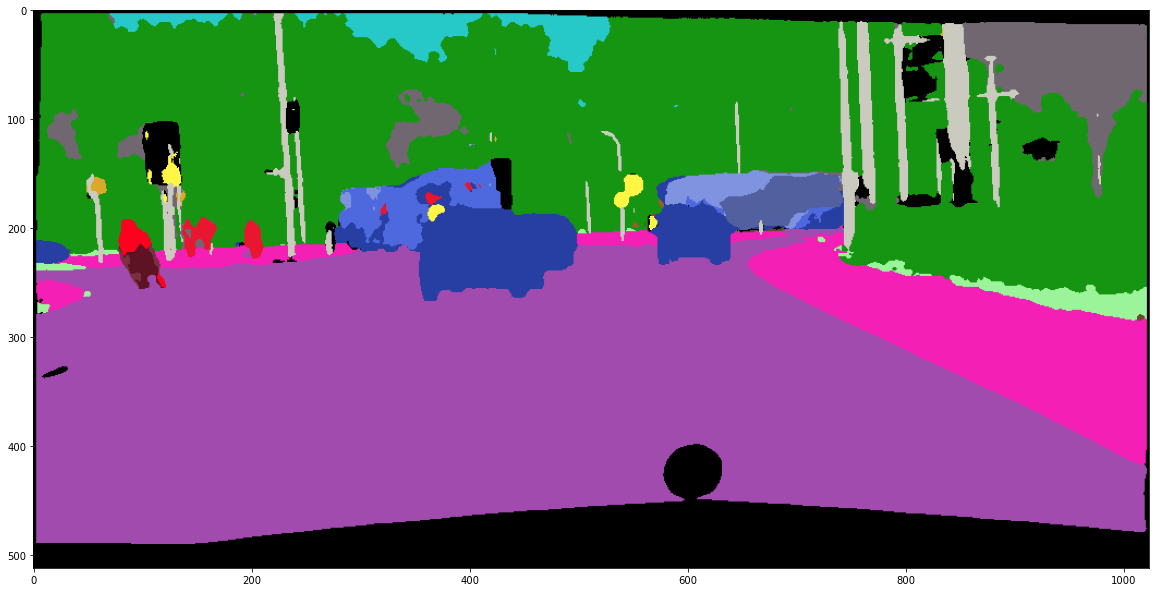

In [20]:
colorify(idxs.cpu(), (512,1024))